# Stack Overflow: Tag Prediction

# -----------------------------------------------------------------------------------------------------

<h1>Business Problem </h1>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<h2>Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>Machine Learning problem </h1>

<h2>Data </h2>

__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h2>Performance metric </h2>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

# -----------------------------------------------------------------------------------------------------

# Assignment

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

# Approach: 

<h3> Task 1:</h3>

<p> For bag of words we took ngram range from 1 to 4 on a set of 100k training points.</p>
<p> If we take more than 100k points, the system keeps on crashing and it does not complete </p>

<h3> Task 2 and 3:</h3>

<h3> 1. Vectorization of data </h3>

<p> For Log Reg and Lr SVM, we took 400k train points and vectorized it with Tf-Idf   and ngram range of 1 to 3 </p>

<h3> 2. Training the models with hyperparam tunning </h3>

<p> Performed Grid Search and used the F1 score to find the best alpha for the model </p>

# Findings:-

In [81]:
printFinalResults()

+-------+-----------------+-------------------+-----------+--------+---------+
| Task# |       Desc      |     Score Desc    | Precision | Recall | F1Score |
+-------+-----------------+-------------------+-----------+--------+---------+
|   1   | BOW(Ngram=(1,4) |    Micro Scores   |    0.56   |  0.36  |   0.44  |
|   1   | BOW(Ngram=(1,4) |  Avg Micro Scores |    0.54   |  0.36  |   0.43  |
|   2   |    LR Hyp Tun   | Best Micro Scores |    0.69   |  0.38  |   0.49  |
|   2   |    LR Hyp Tun   | Avg  Micro Scores |    0.65   |  0.39  |   0.48  |
|   3   |  Lr SVM Hyp Tun | Best Micro Scores |    0.71   |  0.39  |   0.51  |
|   3   |  Lr SVM Hyp Tun | Avg  Micro Scores |    0.64   |  0.39  |   0.47  |
+-------+-----------------+-------------------+-----------+--------+---------+
+-------+-----------------+----------+--------------+
| Task# |       Desc      | Accuracy | Hamming Loss |
+-------+-----------------+----------+--------------+
|   1   | BOW(Ngram=(1,4) |   0.18   |    0.003 

# -----------------------------------------------------------------------------------------------------

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import winsound
from wordcloud import WordCloud
import nltk
import re
from prettytable import PrettyTable
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from datetime import datetime

# Db Related Functions

In [2]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

# 1. Db creation with sample size=0.5M , 500 tags and more weight to title

In [3]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer,title);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [4]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


# 2.Preprocessing of questions

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [5]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [6]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code,title)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code,title) values (?,?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:17:50.794231


In [7]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [3]:
write_db = 'Titlemoreweight.db'

In [4]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

__ Taking 0.5 Million entries to a dataframe. __

In [5]:
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [6]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [6]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


# 3.Converting string Tags to multilable output variables

In [7]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

<h3>3.1 Selecting 500 Tags</h3>

In [8]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [9]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

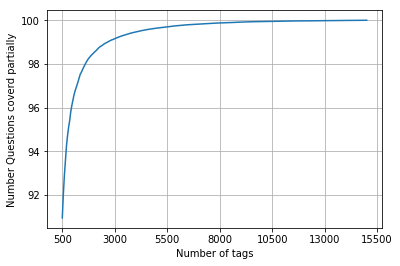

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [16]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [17]:
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.ds-store', '.each', '.emf']


In [18]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = multilabel_y.sum(axis=0).A1
result = dict(zip(tags, freqs))

<h3>3.2 Most Frequent Tags </h3>

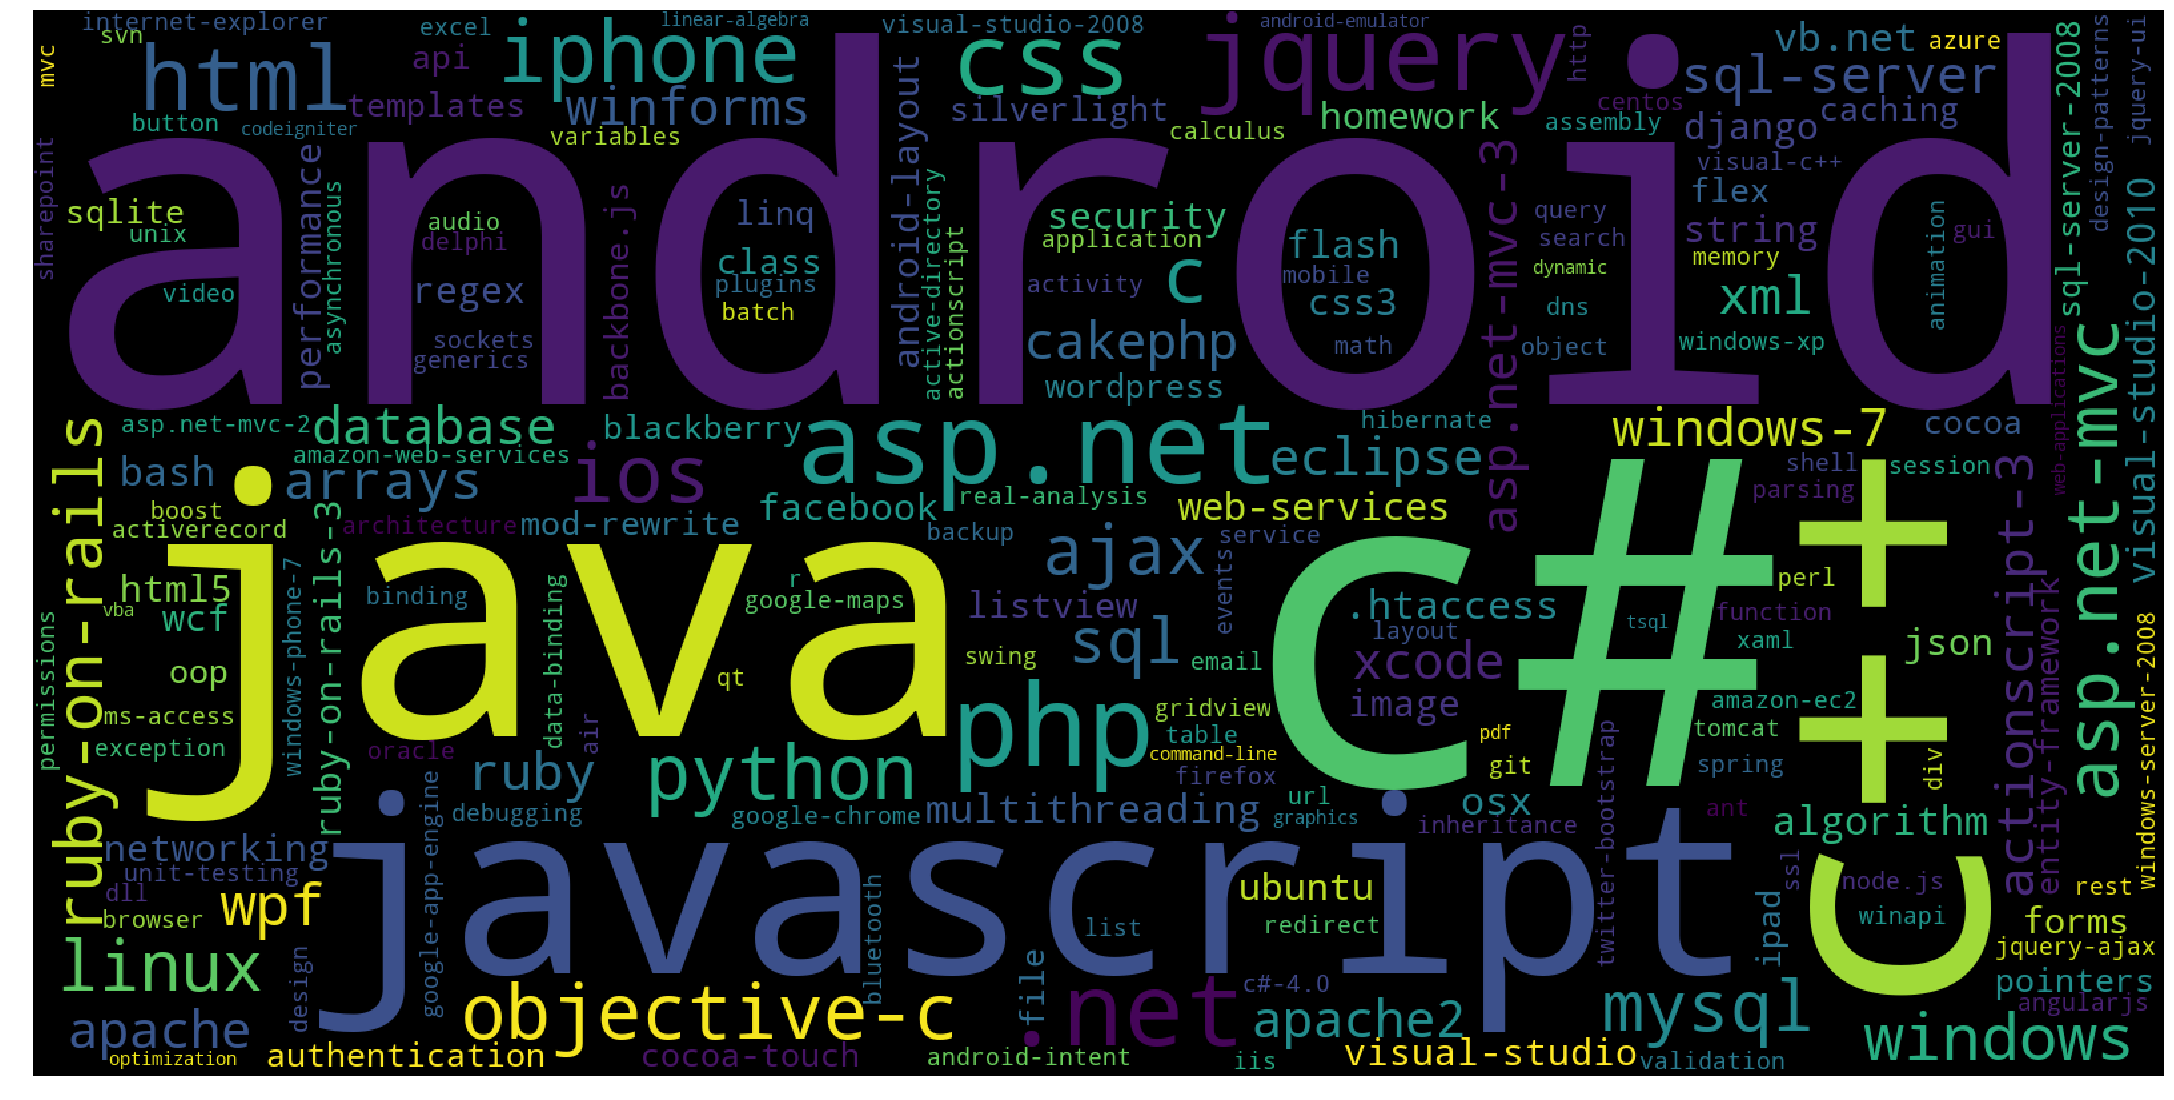

Time taken to run this cell : 0:00:03.524736


In [19]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

In [10]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


# 4.Train Test Split

In [11]:
X=preprocessed_data
X.shape

(500000, 2)

### For task 1 i.e BOW with ngram = 1,4, limiting the train data set size to 100,000 as more than it is crashing the system 

In [59]:
train_datasize=100000
test_datasize=20000

In [60]:
x_train_task1=X[0:train_datasize]
x_test_task1=X[train_datasize: train_datasize + test_datasize]

y_train_task1 = multilabel_yx[0:train_datasize,:]
y_test_task1 = multilabel_yx[train_datasize:train_datasize + test_datasize,:]

In [61]:
print("Number of data points in train data :", x_train_task1.shape)
print("Number of data points in test data :", x_test_task1.shape)

print("Number of data points in train data :", y_train_task1.shape)
print("Number of data points in test data :", y_test_task1.shape)

Number of data points in train data : (100000, 2)
Number of data points in test data : (20000, 2)
Number of data points in train data : (100000, 500)
Number of data points in test data : (20000, 500)


### For task 2 and 3 taking the train data set size of 400,000 

In [12]:
train_datasize=400000
test_datasize=100000

In [13]:
x_train_task_2_3=X[0:train_datasize]
x_test_task_2_3=X[train_datasize: train_datasize + test_datasize]

y_train_task_2_3 = multilabel_yx[0:train_datasize,:]
y_test_task_2_3 = multilabel_yx[train_datasize:train_datasize + test_datasize,:]

In [14]:
print("Number of data points in train data :", x_train_task_2_3.shape)
print("Number of data points in test data :", x_test_task_2_3.shape)

print("Number of data points in train data :", y_train_task_2_3.shape)
print("Number of data points in test data :", y_test_task_2_3.shape)

Number of data points in train data : (400000, 2)
Number of data points in test data : (100000, 2)
Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


# ----------------------------------------------------------------------------------------

In [15]:
def myScore(y_orig,y_pred):
    f1_microScore = f1_score(y_orig, y_pred, average='micro')
    return f1_microScore

In [16]:
from sklearn.metrics.scorer import make_scorer
my_scorer = make_scorer(myScore, greater_is_better=True)

In [17]:
def returnMetricScores(x,y,clf):
    pred = clf.predict(x)

    #Micro Scores
    precision_micro = precision_score(y, pred, average='micro')
    recall_micro = recall_score(y, pred, average='micro')
    f1_micro = f1_score(y, pred, average='micro')

    #Macro scores
    precision_macro = precision_score(y, pred, average='macro')
    recall_macro = recall_score(y, pred, average='macro')
    f1_macro = f1_score(y, pred, average='macro')
    
    return pred,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro

In [68]:
class bcolors:
    GREEN = '\033[1;92m'
    ENDC = '\033[0m'
    RED = '\033[1;31m'
    BLUE = '\033[1;94m'
    YELLOW = '\033[1;93m'

In [47]:
def generateReportTabular(report):
    lines = report.split('\n')
    pTable=PrettyTable()
    pTable.field_names =  [bcolors.RED +"TagNo", "Precision", "Recall", "F1-Score", "Support" + bcolors.ENDC]
    for line in lines[2:502]:
        row = {}
        row_data = line.split('      ')
        pTable.add_row([bcolors.GREEN +row_data[1], row_data[2], row_data[3],row_data[4], row_data[5]  + bcolors.ENDC])

    row_data1 = lines[503].split()
    temp=row_data1[0]+row_data1[1]+row_data1[2]
    pTable.add_row([bcolors.RED +'', '', '','',''+ bcolors.ENDC])
    pTable.add_row([bcolors.RED +temp, row_data1[3], row_data1[4],row_data1[5], row_data1[6]  + bcolors.ENDC])
    print(pTable)

In [20]:
def returnF1Scores(x,y,clf):
    pred = clf.predict(x)
    f1_micro = f1_score(y, pred, average='micro')
    return f1_micro

In [76]:
def printFinalResults():
    ptt = PrettyTable()
    ptt.field_names = [bcolors.RED +"Task#","Desc", "Score Desc","Precision", "Recall", "F1Score" + bcolors.ENDC]

    ptt.add_row([bcolors.YELLOW +"1","BOW(Ngram=(1,4)","Micro Scores", 0.56, 0.36,str(0.44) + bcolors.ENDC])
    ptt.add_row([bcolors.YELLOW +"1","BOW(Ngram=(1,4)","Avg Micro Scores", 0.54, 0.36,str(0.43) + bcolors.ENDC])

    ptt.add_row([bcolors.GREEN +"2","LR Hyp Tun","Best Micro Scores", 0.69, 0.38,str(0.49) + bcolors.ENDC])
    ptt.add_row([bcolors.GREEN +"2","LR Hyp Tun","Avg  Micro Scores", 0.65, 0.39,str(0.48) + bcolors.ENDC])

    ptt.add_row([bcolors.BLUE +"3","Lr SVM Hyp Tun","Best Micro Scores", 0.71, 0.39,str(0.51) + bcolors.ENDC])
    ptt.add_row([bcolors.BLUE +"3","Lr SVM Hyp Tun","Avg  Micro Scores", 0.64, 0.39,str(0.47) + bcolors.ENDC])
    print(ptt)
    
    ptt = PrettyTable()
    ptt.field_names = [bcolors.RED +"Task#","Desc", "Accuracy","Hamming Loss" + bcolors.ENDC]

    ptt.add_row([bcolors.YELLOW +"1","BOW(Ngram=(1,4)",0.18,str(0.003) + bcolors.ENDC])
    ptt.add_row([bcolors.GREEN +"2","LR Hyp Tun", 0.25,str(0.002) + bcolors.ENDC])
    ptt.add_row([bcolors.BLUE +"3","Lr SVM Hyp Tun", 0.26,str(0.002) + bcolors.ENDC])
    print(ptt)
    

### Sample of how to generate a table with colours

In [202]:
ptt = PrettyTable()
#x.border = 
ptt.field_names = [bcolors.RED +"ColA", "ColB", "ColC", "ColD", "ColE" + bcolors.ENDC]

ptt.add_row([bcolors.GREEN +"Adelaide", 1295, 1158259, 600.5,33])
ptt.add_row(["Brisbane", 5905, 1857594, 1146.4,44])

print(ptt)

+----------+------+---------+--------+------+
|   ColA   | ColB |   ColC  |  ColD  | ColE |
+----------+------+---------+--------+------+
| Adelaide | 1295 | 1158259 | 600.5  |  33  |
| Brisbane | 5905 | 1857594 | 1146.4 |  44  |
+----------+------+---------+--------+------+


# ----------------------------------------------------------------------------------------

# Task 1: BOW with ngram upto 4 and find F1 score with LR (OVR)

In [69]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, ngram_range=(1,4))
x_train_multilabel_task1 = vectorizer.fit_transform(x_train_task1['question'])
x_test_multilabel_task1 = vectorizer.transform(x_test_task1['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:36.323200


In [70]:
print("Dimensions of train data X:",x_train_multilabel_task1.shape, "Y :",y_train_task1.shape)
print("Dimensions of test data X:",x_test_multilabel_task1.shape,"Y:",y_test_task1.shape)

Dimensions of train data X: (100000, 115227) Y : (100000, 500)
Dimensions of test data X: (20000, 115227) Y: (20000, 500)


<h3>  Applying Logistic Regression  OneVsRest Classifier </h3>

In [48]:
warnings.filterwarnings("ignore")

In [72]:
start = datetime.now()
clfBow = OneVsRestClassifier(LogisticRegression(penalty='l1'))# n_jobs=-1)
clfBow.fit(x_train_multilabel_task1, y_train_task1)
print("Time taken to run OneVsRestClassifier for Log Reg for 100k points :", datetime.now() - start)

Time taken to run OneVsRestClassifier for Log Reg for 100k points : 0:30:30.661893


### Metrics calculation

In [76]:
y_pred,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro = returnMetricScores(
    x_test_multilabel_task1,
    y_test_task1,
    clfBow
)

In [77]:
print("Accuracy :",metrics.accuracy_score(y_test_task1, y_pred))
print("Hamming loss ",metrics.hamming_loss(y_test_task1,y_pred))
print("*" *100)
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro, recall_micro, f1_micro))
print("*" *100)
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro, recall_macro, f1_macro))

Accuracy : 0.1833
Hamming loss  0.0032975
****************************************************************************************************
Micro-average quality numbers
Precision: 0.5688, Recall: 0.3617, F1-measure: 0.4422
****************************************************************************************************
Macro-average quality numbers
Precision: 0.4088, Recall: 0.2790, F1-measure: 0.3194


In [196]:
report= metrics.classification_report(y_test_task1, y_pred)
generateReportTabular(report)

+-------------+-----------+--------+----------+---------+
|    TagNo    | Precision | Recall | F1-Score | Support |
+-------------+-----------+--------+----------+---------+
|        0    |    0.90   |  0.72  |   0.80   |   1617  |
|        1    |    0.41   |  0.20  |   0.27   |   1833  |
|        2    |    0.65   |  0.40  |   0.50   |   1164  |
|        3    |    0.43   |  0.22  |   0.29   |    264  |
|        4    |    0.58   |  0.41  |   0.48   |   1465  |
|        5    |    0.61   |  0.43  |   0.51   |    793  |
|        6    |    0.64   |  0.39  |   0.49   |   1119  |
|        7    |    0.80   |  0.62  |   0.70   |   1432  |
|        8    |    0.22   |  0.13  |   0.16   |    491  |
|        9    |    0.56   |  0.45  |   0.50   |    539  |
|       10    |    0.31   |  0.25  |   0.28   |    660  |
|       11    |    0.56   |  0.45  |   0.50   |    919  |
|       12    |    0.48   |  0.30  |   0.37   |    741  |
|       13    |    0.25   |  0.14  |   0.18   |     98  |
|       14    

# ----------------------------------------------------------------------------------------

### Vectorizer to be used for Task 2 and 3. Tf-Idf with 400k train size

In [21]:
start = datetime.now()
vectorizer_tfidf = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer= lambda x : x.split(), ngram_range=(1,3))
x_train_multilabel_task_2_3 = vectorizer_tfidf.fit_transform(x_train_task_2_3['question'])
x_test_multilabel_task_2_3 = vectorizer_tfidf.transform(x_test_task_2_3['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:14:40.970054


In [50]:
print("Dimensions of train data X:",x_train_multilabel_task_2_3.shape, "Y :",y_train_task_2_3.shape)
print("Dimensions of test data X:",x_test_multilabel_task_2_3.shape,"Y:",y_test_task_2_3.shape)

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (100000, 500)


# Task 2: Hyper param tuning for alpha in LR

In [53]:
start = datetime.now()
tuned_parameters = [10**-10,10**-9,10**-8,10**-7,10**-6,10**-5,10**-4,10**-3]
f1_micro_scores ={}
for i in tuned_parameters:
    start1 = datetime.now()
    clfLR = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1',alpha=i,random_state=42))
    clfLR.fit(x_train_multilabel_task_2_3, y_train_task_2_3)
    f1_micro_scores.update({i: returnF1Scores(x_test_multilabel_task_2_3,y_test_task_2_3,clfLR)}) 
    print('Process completed for alpha : %s . \tTime taken : %s ' %(i,datetime.now() - start1))

print('Time taken to tune alpha with 400k points and 5 values of alpha : %s ' %(datetime.now() - start))
print('The F1 scores are : %s' %(f1_micro_scores))    

winsound.MessageBeep(1)

Process completed for alpha : 1e-10 . 	Time taken : 0:24:13.712494 
Process completed for alpha : 1e-09 . 	Time taken : 0:23:52.682986 
Process completed for alpha : 1e-08 . 	Time taken : 0:23:44.068825 
Process completed for alpha : 1e-07 . 	Time taken : 0:25:09.357605 
Process completed for alpha : 1e-06 . 	Time taken : 0:21:17.901763 
Process completed for alpha : 1e-05 . 	Time taken : 0:18:30.258544 
Process completed for alpha : 0.0001 . 	Time taken : 0:17:03.902723 
Process completed for alpha : 0.001 . 	Time taken : 0:16:15.934177 
Time taken to tune alpha with 400k points and 5 values of alpha : 2:50:07.824013 
The F1 scores are : {1e-10: 0.44659722546592556, 1e-09: 0.4478529762037796, 1e-08: 0.4510468749493029, 1e-07: 0.46552433264342197, 1e-06: 0.4983007929632838, 1e-05: 0.44810243066573585, 0.0001: 0.297847850403093, 0.001: 0.0631701309125128}


In [54]:
import operator
sorted_F1_score = sorted(f1_micro_scores.items(), key=operator.itemgetter(1))
bestAlpha = sorted_F1_score[len(sorted_F1_score)-1][0]
print('Best alpha after hyper param tunning is : %s ' %(bestAlpha))

Best alpha after hyper param tunning is : 1e-06 


<h3> Training the model with best hyper params </h3>

In [55]:
clf=OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1',alpha=bestAlpha,random_state=42))
clf.fit(x_train_multilabel_task_2_3,y_train_task_2_3)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=1)

### Metrics calculation

In [56]:
y_pred,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro = returnMetricScores(
    x_test_multilabel_task_2_3,
    y_test_task_2_3,
    clf
)

In [57]:
print("Accuracy :",metrics.accuracy_score(y_test_task_2_3, y_pred))
print("Hamming loss ",metrics.hamming_loss(y_test_task_2_3,y_pred))
print("*" *100)
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro, recall_micro, f1_micro))
print("*" *100)
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro, recall_macro, f1_macro))

Accuracy : 0.25315
Hamming loss  0.00271044
****************************************************************************************************
Micro-average quality numbers
Precision: 0.6988, Recall: 0.3872, F1-measure: 0.4983
****************************************************************************************************
Macro-average quality numbers
Precision: 0.5563, Recall: 0.3100, F1-measure: 0.3835


In [58]:
report= metrics.classification_report(y_test_task_2_3, y_pred)
generateReportTabular(report)

+-----------+-----------+--------+----------+---------+
|   TagNo   | Precision | Recall | F1-Score | Support |
+-----------+-----------+--------+----------+---------+
|       0   |    0.93   |  0.75  |   0.83   |   5519  |
|       1   |    0.65   |  0.40  |   0.49   |   8190  |
|       2   |    0.79   |  0.42  |   0.55   |   6529  |
|       3   |    0.80   |  0.51  |   0.62   |   3231  |
|       4   |    0.75   |  0.48  |   0.58   |   6430  |
|       5   |    0.80   |  0.42  |   0.55   |   2879  |
|       6   |    0.84   |  0.56  |   0.67   |   5086  |
|       7   |    0.86   |  0.59  |   0.70   |   4533  |
|       8   |    0.57   |  0.15  |   0.24   |   3000  |
|       9   |    0.80   |  0.58  |   0.67   |   2765  |
|      10   |    0.57   |  0.21  |   0.30   |   3051  |
|      11   |    0.66   |  0.42  |   0.51   |   3009  |
|      12   |    0.58   |  0.32  |   0.42   |   2630  |
|      13   |    0.71   |  0.34  |   0.46   |   1426  |
|      14   |    0.89   |  0.59  |   0.71   |   

# ----------------------------------------------------------------------------------------

# Task 3: OVR with Linear SVM

In [23]:
start = datetime.now()
#tuned_parameters = [10**-7,10**-5,10**-3,10**-1,10**1]
tuned_parameters = [10**-10,10**-9,10**-8,10**-7,10**-6,10**-4,10**-3]
f1_micro_scores_svm ={}
for i in tuned_parameters:
    start1 = datetime.now()
    clfSVM = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',alpha=i))
    clfSVM.fit(x_train_multilabel_task_2_3, y_train_task_2_3)
    f1_micro_scores_svm.update({i: returnF1Scores(x_test_multilabel_task_2_3,y_test_task_2_3,clfSVM)}) 
    print('Process completed for alpha : %s . \tTime taken : %s ' %(i,datetime.now() - start1))
    
print('Time taken to tune alpha with 400k points and 5 values of alpha : %s ' %(datetime.now() - start))
print('The F1 scores are : %s' %(f1_micro_scores_svm))    

winsound.MessageBeep(1)

Process completed for alpha : 1e-10 . 	Time taken : 0:17:31.686442 
Process completed for alpha : 1e-09 . 	Time taken : 0:16:48.785858 
Process completed for alpha : 1e-08 . 	Time taken : 0:17:14.566418 
Process completed for alpha : 1e-07 . 	Time taken : 0:17:51.121659 
Process completed for alpha : 1e-06 . 	Time taken : 0:14:47.170453 
Process completed for alpha : 0.0001 . 	Time taken : 0:12:02.788742 
Process completed for alpha : 0.001 . 	Time taken : 0:11:51.288914 
Time taken to tune alpha with 400k points and 5 values of alpha : 1:48:07.420631 
The F1 scores are : {1e-10: 0.44942769941123145, 1e-09: 0.4451771578867505, 1e-08: 0.45293850640211347, 1e-07: 0.45582166698393545, 1e-06: 0.5051363090287404, 0.0001: 0.33551620692178236, 0.001: 0.16269824794486423}


In [24]:
import operator
sorted_F1_score_SVM = sorted(f1_micro_scores_svm.items(), key=operator.itemgetter(1))
bestAlphaSvm = sorted_F1_score_SVM[len(sorted_F1_score_SVM)-1][0]
print('Best alpha after hyper param tunning is : %s ' %(bestAlphaSvm))

Best alpha after hyper param tunning is : 1e-06 


<h3> Training the model with best hyper params </h3>

In [25]:
clfSVM=OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',alpha=bestAlphaSvm))
clfSVM.fit(x_train_multilabel_task_2_3,y_train_task_2_3)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1)

### Metrics calculation

In [26]:
y_pred,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro = returnMetricScores(
    x_test_multilabel_task_2_3,
    y_test_task_2_3,
    clfSVM
)

C:\Users\rahul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rahul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
print("Accuracy :",metrics.accuracy_score(y_test_task_2_3, y_pred))
print("Hamming loss ",metrics.hamming_loss(y_test_task_2_3,y_pred))
print("*" *100)
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro, recall_micro, f1_micro))
print("*" *100)
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro, recall_macro, f1_macro))

Accuracy : 0.26131
Hamming loss  0.00267308
****************************************************************************************************
Micro-average quality numbers
Precision: 0.7075, Recall: 0.3939, F1-measure: 0.5061
****************************************************************************************************
Macro-average quality numbers
Precision: 0.5484, Recall: 0.3071, F1-measure: 0.3706


In [49]:
report= metrics.classification_report(y_test_task_2_3, y_pred)
generateReportTabular(report)

+-----------+-----------+--------+----------+---------+
|   TagNo   | Precision | Recall | F1-Score | Support |
+-----------+-----------+--------+----------+---------+
|       0   |    0.92   |  0.78  |   0.84   |   5519  |
|       1   |    0.63   |  0.39  |   0.48   |   8190  |
|       2   |    0.75   |  0.46  |   0.57   |   6529  |
|       3   |    0.75   |  0.56  |   0.64   |   3231  |
|       4   |    0.74   |  0.48  |   0.58   |   6430  |
|       5   |    0.75   |  0.45  |   0.56   |   2879  |
|       6   |    0.81   |  0.58  |   0.68   |   5086  |
|       7   |    0.79   |  0.66  |   0.72   |   4533  |
|       8   |    0.56   |  0.14  |   0.23   |   3000  |
|       9   |    0.76   |  0.62  |   0.68   |   2765  |
|      10   |    0.52   |  0.24  |   0.33   |   3051  |
|      11   |    0.63   |  0.46  |   0.53   |   3009  |
|      12   |    0.57   |  0.32  |   0.41   |   2630  |
|      13   |    0.64   |  0.36  |   0.46   |   1426  |
|      14   |    0.88   |  0.62  |   0.73   |   